> ### EEE4423: Deep Learning Lab

# LAB \#11: Character Generation using LSTM

<h4><div style="text-align: right"> Due date: May 18, 2023. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 2 PM in the form of [ID_Name_Lab11.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-18 02:30:02.629776


In [2]:
!pip install unidecode --user

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import unidecode
import string
import random
import re
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

These sorts of generative models form the basis of machine translation, image captioning, question answering and more.

<img src="http://drive.google.com/uc?export=view&id=16E7HG_dCyfTo9u9qrrhp2eClq6xK6-f_" style="width: 600px;"/>

### 1. Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package

<img src="http://drive.google.com/uc?export=view&id=171lX3vxj60AQNScQi872BHx2Rz6J7-3J" />

In [4]:
file = unidecode.unidecode(open('./dataset-dllab/lab11/lose_yourself_eminem.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4063


To make inputs out of this big string of data, we will be splitting it into chunks.

In [5]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

clocks run out, times up, over, blaow!
Snap back to reality, oh there goes gravity
Oh, there goes Rabbit, he choked
He's so mad, but he won't give up that easy? No
He won't have it, he knows his whole 


Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
# Turn string into list of longs
all_characters = string.printable
print(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print('abcDEF is changed to ', char_tensor('abcDEF'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

abcDEF is changed to  tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [7]:
def random_training_set():    
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

### 2. Build the LSTM model [4 points]

#### [Diagram of LSTM]
<img src="http://drive.google.com/uc?export=view&id=1baQ6Ffu-vDcXbOEBYGeLzhmfvaj4DGgW" style="width: 800px;"/>
LSTM consists of cell state, hidden state and 3 gates that modify or use the cell state. The cell state is the key part of the LSTM and you can think that information "flows" in there. The operation of 3 gates are described in below.

#### [Forget Gate]
The forget gate determines which information in the cell state should be erased.
<img src="http://drive.google.com/uc?export=view&id=1sJisl5P0hggmvH4qrcYgSETFKdFdBSH_" style="width: 600px;"/>

#### [Input Gate]
First, the candidate cell state is created using the current input and the previous hidden state. And the input gate determines how much the candidate cell state is reflected to the cell state.
<img src="http://drive.google.com/uc?export=view&id=1Df-k5FORGH7PnXauYcb8qqUpY3Uot9A7" style="width: 600px;"/>

#### [Output Gate]
The output gate determines which elements should be extracted from the cell state to produce the output.
<img src="http://drive.google.com/uc?export=view&id=1JLCGPcrZLOYfjyJhMTvmfixHq5plFj8L" style="width: 600px;"/>

The above expression is summarized as follows,
<img src="http://drive.google.com/uc?export=view&id=1kGq8DwwzizuNcg6GF0GaP1DAu26FFlrB" style="width: 300px;"/>


This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one LSTM layer that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        self.encoder = nn.Embedding(input_dim, hidden_dim)
        
        # lstm
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #size of input (1,1,100)
        
        #############
        self.f=nn.Sequential(
        nn.Linear(input_dim+hidden_dim,hidden_dim),
        nn.Sigmoid())
        
        self.i=nn.Sequential(
        nn.Linear(input_dim+hidden_dim, hidden_dim),
        nn.Sigmoid())
        
        self.c=nn.Sequential(
        nn.Linear(input_dim+hidden_dim,hidden_dim),
        nn.Tanh())
        
        self.o=nn.Sequential(
        nn.Linear(input_dim+hidden_dim, hidden_dim),
        nn.Sigmoid())
        
        self.tanh=nn.Tanh()
        #############
        
        self.decoder = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input, hn, cn):
        #############
        #print('hn:',hn.shape) #(1,1,100)
        #print('cn:',cn.shape) #(1,1,100)
        #print('input:',input.shape) #(1,1)
        #First layer
        enc_vec=self.encoder(input) # (1,1,100)
        
        #Second layer
        hx=torch.cat((hn[0],enc_vec[:,0,:]),1)#차원 순서가 다르기 때문에 차원을 맞추어 concatenation해준다. (1,2*hidden_dim)=(1,200)
        f=self.f(hx)#forget gate의 f
        i=self.i(hx)#input gate의 i
        c_tilda=self.c(hx)#input gate의 c_tilda
        o=self.o(hx)#output gate의 o
        cn=(f*cn[:,0,:]+i*c_tilda).unsqueeze(0)#t에서의 c
        hn=o*self.tanh(cn[:,0,:]).unsqueeze(0)#t에서의 h
        
        #Third layer
        output=self.decoder(hn)
        
        #############
        return output, hn, cn
    
    def init_hidden(self):
        #############
        h0=Variable(torch.zeros((self.layer_dim,1,self.hidden_dim)).cuda())#(layer_dim,batch_size,hidden_dim)
        c0=Variable(torch.zeros((self.layer_dim,1,self.hidden_dim)).cuda())
        #############
        return h0,c0
    
hidden_dim = 100
n_layers = 1
n_characters = len(all_characters)

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters) #100,100,1,100
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (f): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (i): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (c): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Tanh()
  )
  (o): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (tanh): Tanh()
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

### 3. Loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()

lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4 . Write the character level generation code [4 points]

- Generate a sentence with a length of $predict\_len$, starting from a single character $prime\_str$.
- Example) evaluate(prime_str='Y', predict_len=20) -> You better let it go

In [10]:
def evaluate(prime_str='W', predict_len=100):
    # suppose prims_str is a single character
    # and use greedy search to predict the next character

    hn, cn = model.init_hidden()
    predicted=str()
    
    for i in range(predict_len):
        #############
        output,hn,cn=model(char_tensor(prime_str).unsqueeze(0).cuda(),hn,cn)
        prime_str=all_characters[torch.argmax(output[0])]#output[0]에서 가장 높은 확률의 index의 문자가 예측 문자다
        predicted+=prime_str#예측 문자를 이어 sequence를 만든다.
        #############
        
    return predicted
    

### 5 . Write the code to train the model [2 points]

- Plot the training loss curve.
- Print the output sentence with a length of 100, using $evaluate()$ function.

************************* epoch100 *************************
loss 307.9841
 onl one the the the the the the the the the the the the the the the the the the the the the the the 

************************* epoch200 *************************
loss 376.9794
 only go the the the the the the the the the the the the the the the the the the the the the the the 

************************* epoch300 *************************
loss 115.5422
 cames once in the moment
You own it, you better never let it go
You only get one the moment
You own 

************************* epoch400 *************************
loss 291.7099
 he the moment
You own it, you better lose yourself in the moment
You own it, you better lose yourse 

************************* epoch500 *************************
loss 198.7910
 so blows he moment
You own it, you better never let it go
You only get one shot, do not miss your c 

************************* epoch600 *************************
loss 170.5652
 home and sold partna, but the bett

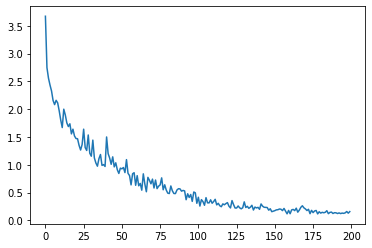

In [11]:
n_epochs = 2000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #############
    # CODE HERE #
    #############
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue
    
    # Clear gradients w.r.t. parameters
    #############
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    #############
    # Forward pass
    loss = 0
    #############
    hn, cn = model.init_hidden()
    for i,index in enumerate(inputs):#input 길이만큼 반복
        output,hn,cn=model(index.unsqueeze(0).unsqueeze(0).cuda(),hn,cn)#dimension을 맞춰준다
        loss+=criterion(output[0],targets[i].unsqueeze(0).cuda())#각각의 index에 대한 loss를 더해준다.
    #############
    # Backward pass
    #############
    loss.backward()
    #############
    # Updating parameters
    #############
    optimizer.step()
    #############
    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

[2] [CS 231n](http://cs231n.stanford.edu/syllabus.html)(http://cs231n.stanford.edu/syllabus.html)

### *Discussion*


그동안 convolution을 이용한 vision문제를 다뤘었는데 이번에는 처음으로 NLP문제를 다뤘다. RNN의 변형 버전인 LSTM을 구현하였는데 LSTM은 RNN의 long-term dependency를 해결하기 위해 cell state를 추가해 이전의 information을 기억하고 forget gate를 통해 information을 취사 선택한다. 따라서 RNN보다 훨씬 복잡한 구조를 가지고 있다.

NLP를 처음 다루어보았기 때문에 데이터의 형태와 변형이 와닿지가 않아 차원을 다루는 것에 조금 어려움이 있었다. 또한 그동안과 다르게 sequential한 data이므로 이것을 단순하게 for문을 써서 loss를 계산해도 되는지에 대해 의문이 있었다. 하지만 결과 그래프를 확인해보았을 때 정상적으로 학습이 진행되는 것을 확인할 수 있다. epoch에 따른 결과물을 살펴보면, epoch이 작을 때는, 특정 단어를 계속 반복하면서 predict가 제대로 되지 않는 모습이 보인다. epoch가 진행될수록 점점 더 그럴듯한 문장을 만들어내지만 epoch가 2000이 되어도, 겉으로 보기에는 그럴듯하지만 의미는 잘 알 수 없는 문장이 나온다. epoch가 부족해서 그런 것일수도 있기 때문에 epoch 2000에 더해서 epoch 3000을 추가적으로 시행한 것을 아래에 첨부한다. 첨부한 결과를 보면, epoch를 2000만 시행했을때보다 훨씬 완성도 있는 문장을 predict하는 것을 볼 수 있다. 추가적으로 재밌는 점은 다른 부분과 다르게 후렴부분은 epoch이 그렇게 크지 않아도 완벽하게 나오는 것을 볼 수 있는데 이는 후렴이 많이 반복되기 때문이라고 생각된다.

한가지 의문점이 있는데 주어진 코드에서 loss를 출력할 때 print와 plot이 다르게 출력된다는 것이다. skeleton에서 print는 loss.item()을 출력하는데 이는 chunk_len, 즉 200만큼의 prediction의 loss를 모두 더한 값이다. 반면에 loss_avg/plot_every는 200만큼의 prediction의 loss를 모두 더한 값에서 chunk_len만큼 나눠준 값 10개의 평균이다. 따라서 print에서 직접적으로 표시되는 loss의 값과 plot에서 볼 수 있는 loss의 값은 대략적으로 200배가 차이가 난다. 게다가 print한 값은 평균 값이 아니라 loss가 튀는 경우가 print될 수 있어 loss가 epoch에 따라 감소하는 모습을 보기가 어렵다. 따라서 합리적이게 생각하면, print도 loss_avg/plot_every로 출력하는 것이 옳다고 생각한다.


************************* epoch100 *************************
loss 51.0012
 been he looks calm and ready
To drop bombly keeps on forgettin'
What he wrote down, the whole crowd 

************************* epoch200 *************************
loss 9.1691
 better never let it go
You only get one shot, do not miss your chance to blow
This opportunity come 

************************* epoch300 *************************
loss 58.5508
 but hole that you calld a lifetime you better
You better lose yourself in the music, the moment
You 

************************* epoch400 *************************
loss 35.1698
 but he won't come out
He's chokin', how, everybody's jokin' now
The clocks run out, times up, over, 

************************* epoch500 *************************
loss 38.6941
 be's no Mekhi Phifer
This is my life and these times are sweaty, knees weak, arms are heavy
There's 

************************* epoch600 *************************
loss 9.5793
 but he's broke
He's so stacked that he kno

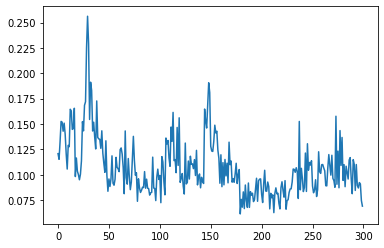

In [12]:
n_epochs = 3000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #############
    # CODE HERE #
    #############
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue
    
    # Clear gradients w.r.t. parameters
    #############
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    #############
    # Forward pass
    loss = 0
    #############
    hn, cn = model.init_hidden()
    for i,index in enumerate(inputs):#input 길이만큼 반복
        output,hn,cn=model(index.unsqueeze(0).unsqueeze(0).cuda(),hn,cn)#dimension을 맞춰준다
        loss+=criterion(output[0],targets[i].unsqueeze(0).cuda())#각각의 index에 대한 loss를 더해준다.
    #############
    # Backward pass
    #############
    loss.backward()
    #############
    # Updating parameters
    #############
    optimizer.step()
    #############
    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)